# 2020-10-23 • Delete signal around spikes before STA

This notebook is similar to {doc}`/notebooks/2020-07-29__STA`, {doc}`/notebooks/2020-09-10__STA_for_different_PSP_shapes`, and {doc}`/notebooks/2020-09-18__Clip_spikes_before_STA`.

We still wonder whether the bump in the STA is due to averaging post synaptic potentials (PSPs), or postsynaptic spikes.

We clipped the signal, but this still kept the ramp-up of the membrane potential right before a spike. It might be this ramp-up that caused the bump (instead of PSPs).

Here we try to get rid of that ramp-up by deleting the VI signal around each spike, by replacing it by a constant value (the median signal value).

We then repeat the STA window procedure to see if the bump is still there, or not.

## Nothing new here

All sections nested under this are the same as in the three previous notebooks.

### Imports & reproducibility info

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading:
 - numpy … (0.28 s)
 - matplotlib.pyplot … (0.49 s)
 - numba … (0.37 s)
 - sympy … (0.39 s)
 - unyt … (1.03 s)

Imported `np`, `mpl`, `plt
Imported package `voltage_to_wiring_sim` as `v`
Imported `*` from `v.util` and from `v.units`
Setup autoreload

Reproducibility info. This notebook was last run on/with:

Fri Oct 23 2020 17:38:10 Romance Daylight Time 

CPython 3.8.3
IPython 7.18.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : yoga
Git hash   : 6872a12c6b6cb764d4daa6093c7f19d03f33e376
Git repo   : git@github.com:tfiers/voltage-to-wiring-sim.git
Git branch : main



### Time grid

In [2]:
tg = v.TimeGrid(T=10 * minute, dt=0.1 * ms)

TimeGrid(T=Quantity(10 min, stored in s, float64), dt=Quantity(0.1 ms, stored in s, float64), N=unyt_quantity(6000000, '(dimensionless)'), t=Array([0 1.667E-06 3.333E-06 ... 10 10 10] min, stored in s, float64))

### Spike trains

'Network' definition.

In [3]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [4]:
f_spike = 20 * Hz

Quantity(20 Hz, stored in Hz, float64)

In [5]:
gen_st = v.generate_Poisson_spike_train

fix_rng_seed()

In [6]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)]

Wall time: 1.48 s


In [7]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

### Time slice

Inspect a time excerpt..

In [8]:
time_slice = 1 * minute + [0, 1] * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice].in_units(second);

..of one presynaptic neuron:


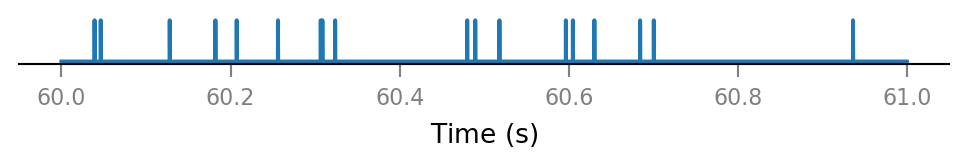

In [9]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice]);

All connected presynaptic neurons:

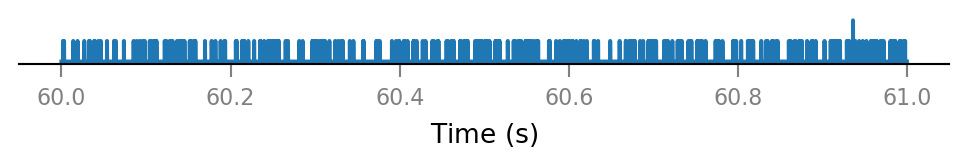

In [10]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

### Synaptic conductance

In [11]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

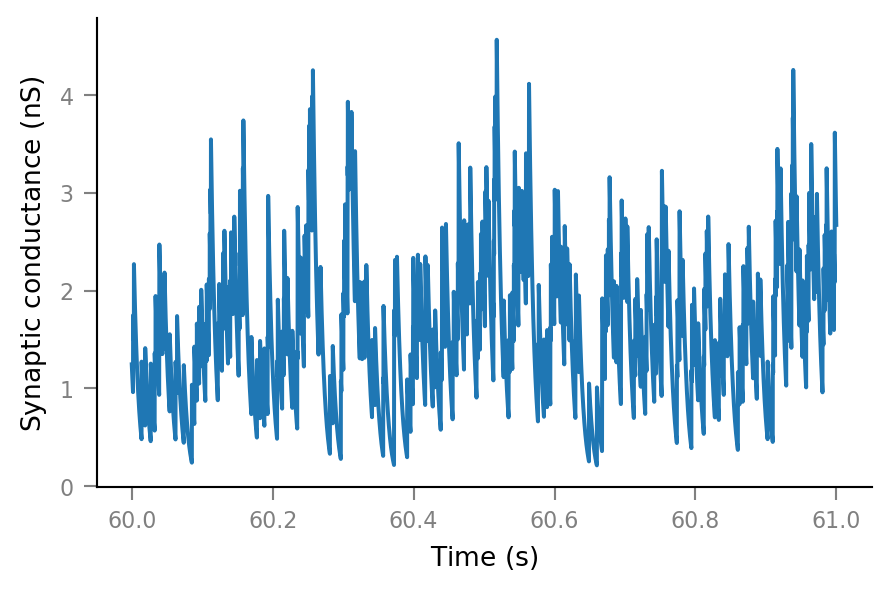

In [12]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice]);

### Membrane voltage

In [13]:
params = v.params.cortical_RS
print(params)

IzhikevichParams
----------------
C = 100 pF
k = 0.7 nS/mV
v_r = -60 mV
v_t = -40 mV
v_peak = 35 mV
a = 0.03 1/ms
b = -2 nS
c = -50 mV
d = 100 pA
v_syn = 0 mV


In [14]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 345 ms


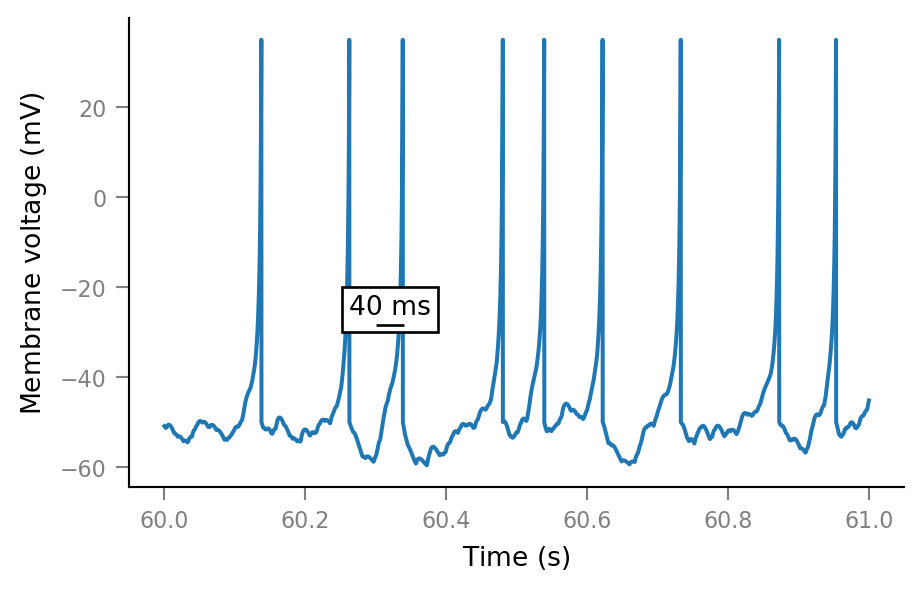

In [15]:
fig, ax = plt.subplots()
ax.plot(t_slice, sim.V_m[i_slice])
add_scalebar(ax, 40 * ms, x=60.32*second, y=-25*mV, frame=True);

### Noise

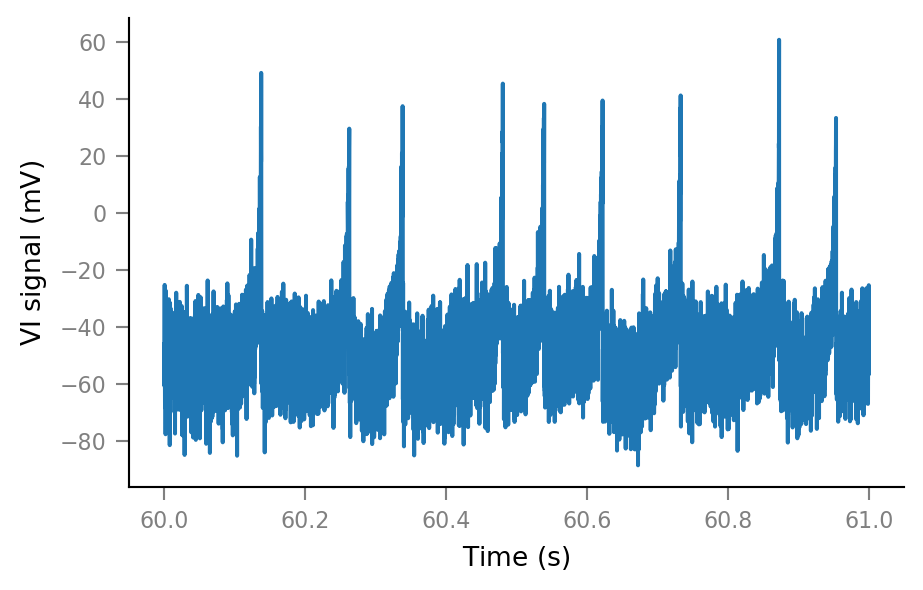

In [16]:
SNR = 10
spike_height = params.v_peak - params.v_r

σ_noise = spike_height / SNR
noise = np.random.randn(tg.N) * σ_noise

Vm_noisy = (sim.V_m + noise).in_units(mV)
Vm_noisy.name = "VI signal"

plt.plot(t_slice, Vm_noisy[i_slice]);

## Find spike times

(Later we'll save spike times at simulation time. For now we detect them post hoc).

In [17]:
from scipy.signal import find_peaks

In [18]:
spikes_ix, _ = find_peaks(Vm_noisy, height=(10 * mV).item(), distance=4 * ms / tg.dt)

`height` argument is minimum peak height.

Peaks are removed, lowest first, until the "`distance` between peaks" argument is satisfied

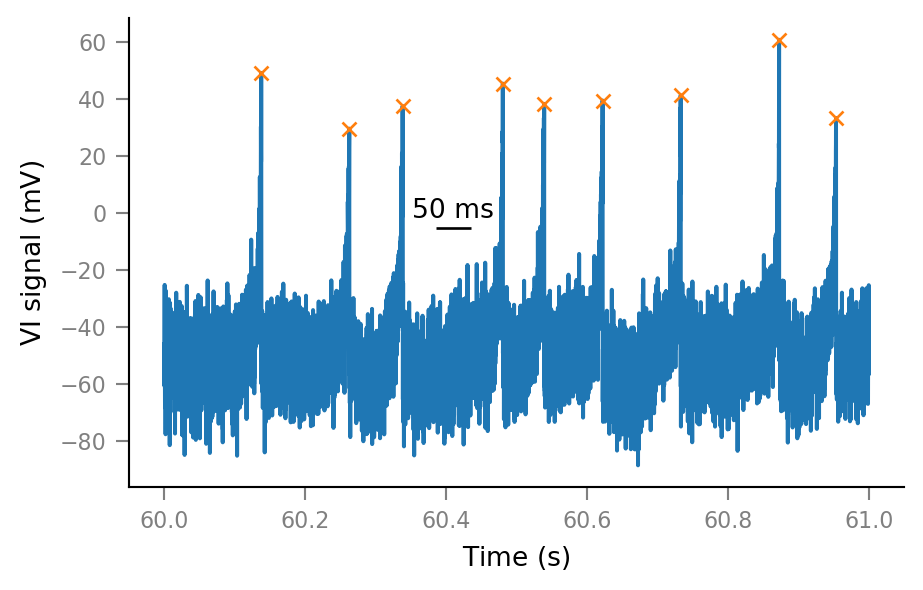

In [19]:
i_start, i_end = slice_indices
spike_ix_slice = spikes_ix[(spikes_ix > i_start) & (spikes_ix < i_end)]

fig, ax = plt.subplots()
ax.plot(t_slice, Vm_noisy[i_slice])
ax.plot(tg.t[spike_ix_slice], Vm_noisy[spike_ix_slice], "x", ms=5)
add_scalebar(ax, 50 * ms, x=60.41 * second, y=0 * mV);

New extended time slice:

In [20]:
time_slice2 = 66 * second + [0, 4] * second
# time_slice2 = 66.6 * second + [0, 100] * ms

slice_indices2 = np.round(time_slice2 / tg.dt).astype(int)
i_slice2 = slice(*slice_indices2)
t_slice2 = tg.t[i_slice2].in_units(second);

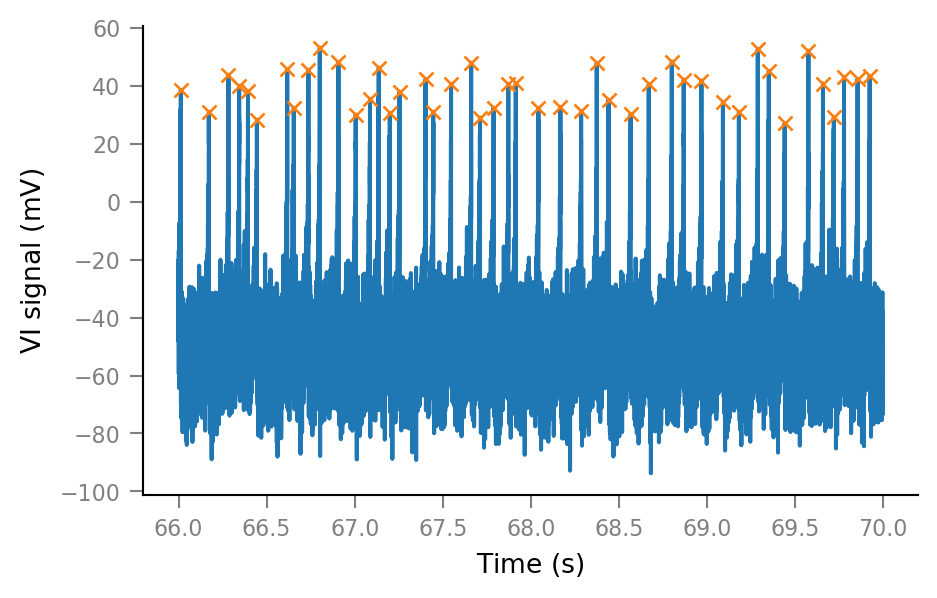

In [21]:
i_start2, i_end2 = slice_indices2
spike_ix_slice2 = spikes_ix[(spikes_ix > i_start2) & (spikes_ix < i_end2)]

plt.plot(t_slice2, Vm_noisy[i_slice2])
plt.plot(tg.t[spike_ix_slice2], Vm_noisy[spike_ix_slice2], "x", ms=5);

## Delete signal around spikes

In [22]:
deletion_frame = [-60 * ms, 20 * ms];  # relative to spike time

In [23]:
deletion_frame_ix = np.array(deletion_frame) / tg.dt.data;

Vm_noisy_redacted = Vm_noisy.copy()

for spike_ix in spikes_ix:
    deletion_ix_slice = slice(*(spike_ix + deletion_frame_ix).astype(int))
    Vm_noisy_redacted[deletion_ix_slice] = np.nan

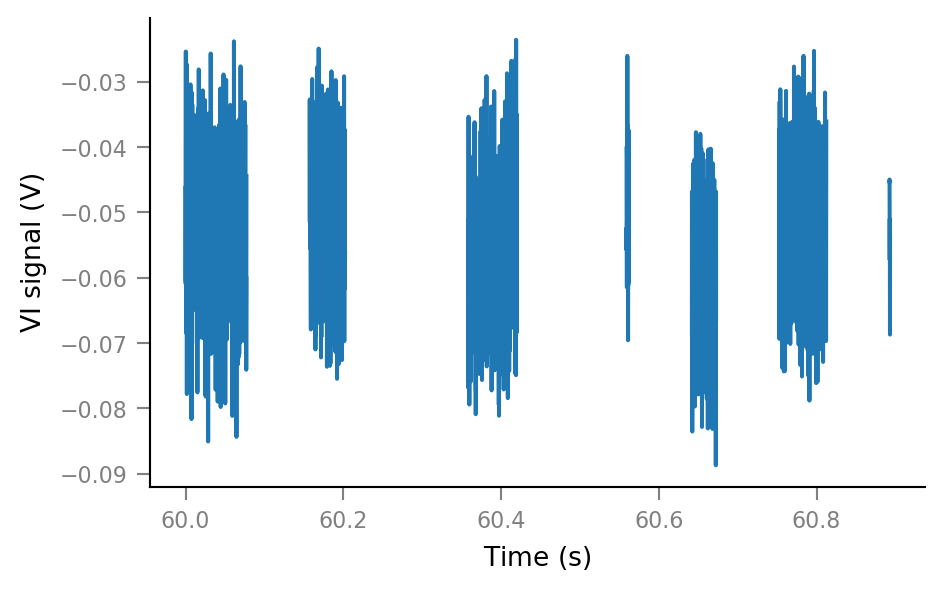

In [24]:
plt.plot(t_slice, Vm_noisy_redacted[i_slice]);

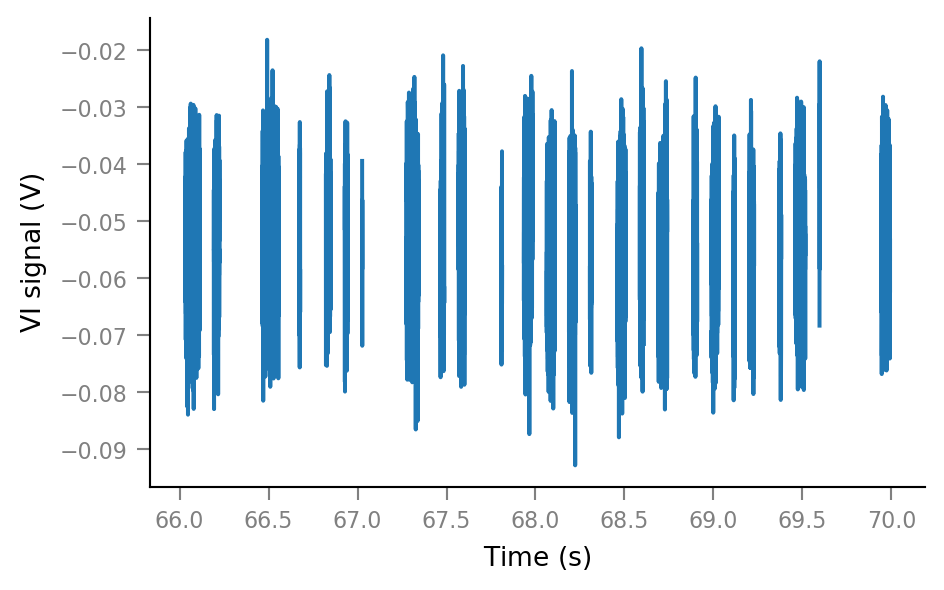

In [25]:
plt.plot(t_slice2, Vm_noisy_redacted[i_slice2]);

## Spike-triggered windows

In [26]:
def get_spike_indices(spike_train):
    # `nonzero` returns a tuple (one element for each array dimension).
    (spike_indices,) = np.nonzero(spike_train)
    return spike_indices

Extract windows from the VI signal.

In [27]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt)
window_tg.t.name = "Time after spike"


# Performance
Vm_noisy_redacted_arr = np.asarray(Vm_noisy_redacted)
window_tg_N = window_tg.N
tg_N = tg.N

import numba

@numba.njit
def _make_windows(spike_indices):
    windows = []
    for ix in spike_indices:
        ix_end = ix + window_tg_N
        if ix_end < tg_N:
            windows.append(Vm_noisy_redacted_arr[ix:ix_end])

    return windows

def make_windows(spike_indices):
    windows = np.stack(_make_windows(spike_indices))
    return Array(windows, V, name=Vm_noisy_redacted.name).in_units(mV)

In [28]:
spike_train__example = all_spike_trains[0]
spike_indices__example = get_spike_indices(spike_train__example)
windows__example = make_windows(spike_indices__example)
windows__example.shape

(12019, 1000)

An example spike-triggered window:

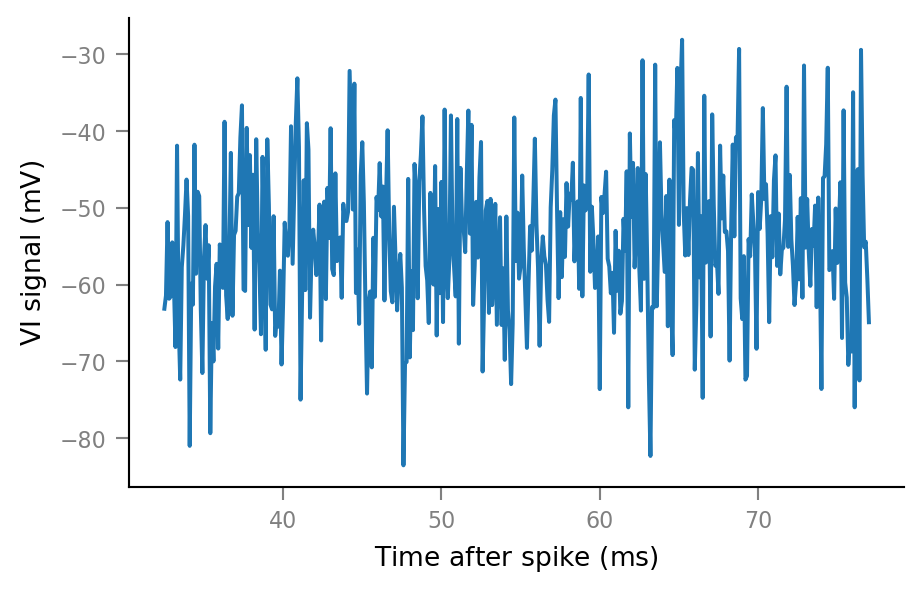

In [29]:
plt.plot(window_tg.t, windows__example[0, :]);

And some more:

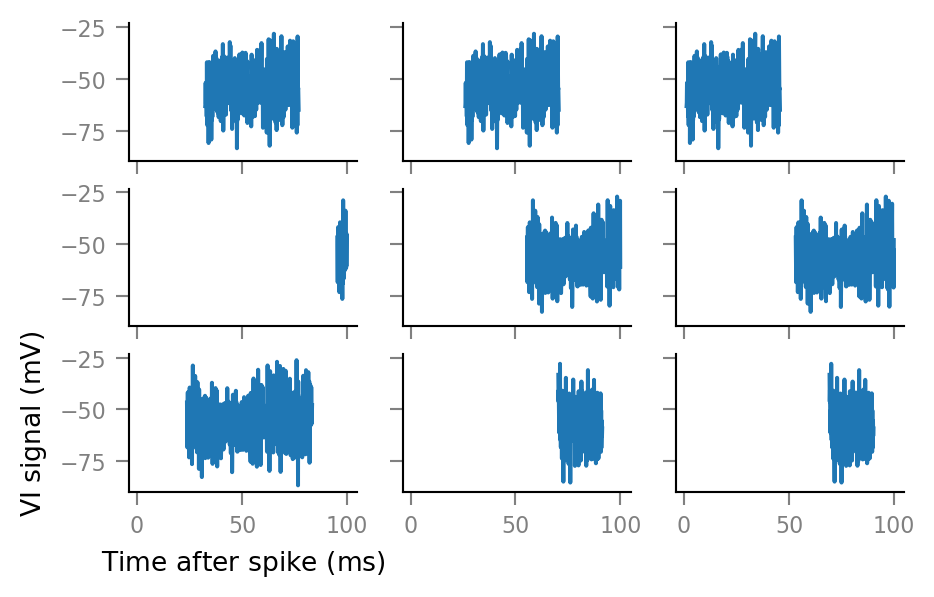

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3 * row + col
        ax.plot(window_tg.t, windows__example[i, :])
        if not (row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

## Average windows

Note that we use `nanmean`, which ignores deleted values (NaN) when taking the mean (instead of making the whole mean result NaN).

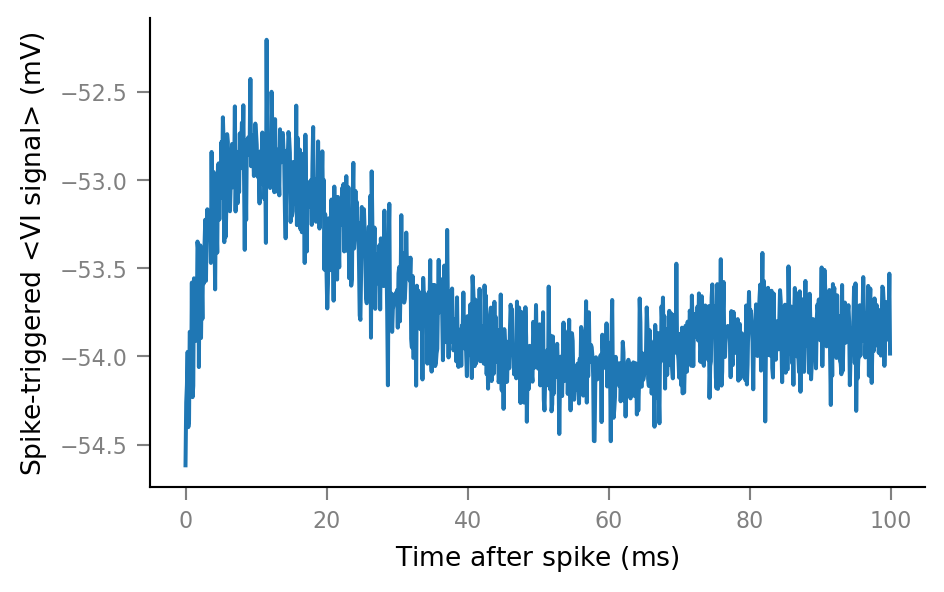

In [31]:
def STA(spike_train):
    spike_indices = get_spike_indices(spike_train)
    windows = make_windows(spike_indices)
    STA = np.nanmean(windows, axis=0)
    return Array(STA, V, name="Spike-triggered <VI signal>").in_units(mV)


def plot_STA(spike_train, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(window_tg.t, STA(spike_train), **kwargs)


plot_STA(spike_trains_connected[0])

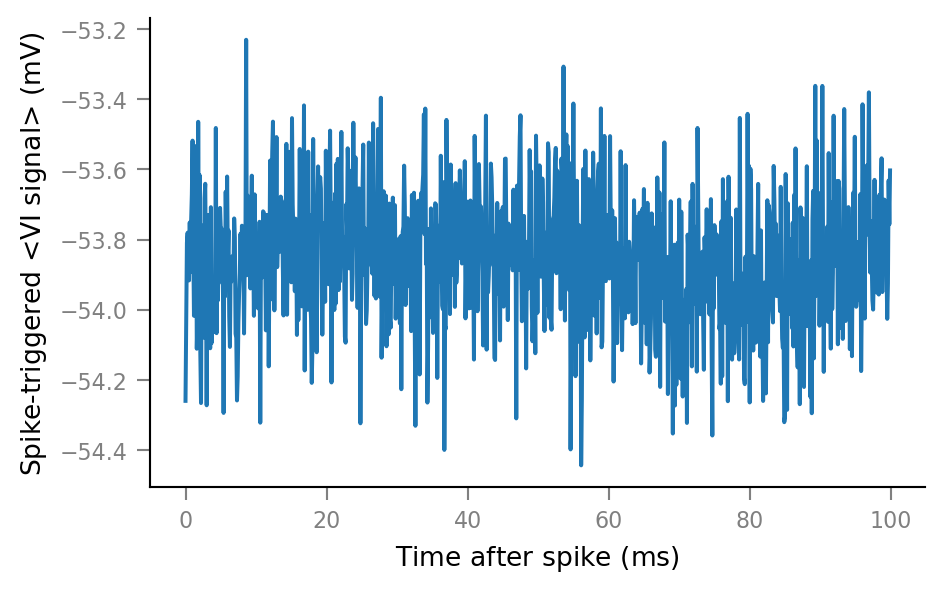

In [32]:
plot_STA(spike_trains_unconnected[0])

## Plot STAs of all spike trains

In [33]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 16.9 s


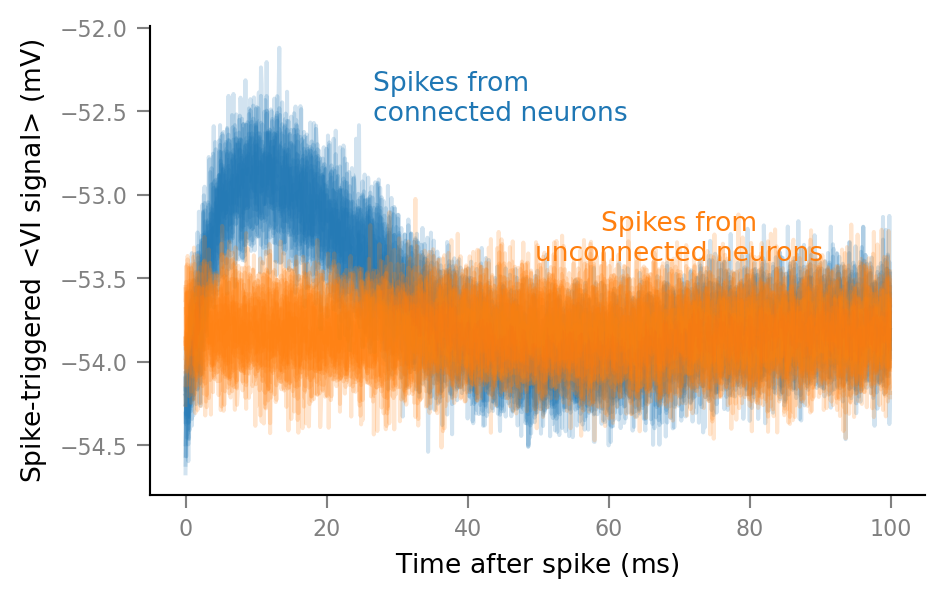

In [34]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate(
    "Spikes from\nconnected neurons",
    xy=(26.55 * ms, 0.8),
    xycoords=("data", "axes fraction"),
    color="C0",
    ha="left",
)

ax.annotate(
    "Spikes from\nunconnected neurons",
    xy=(70 * ms, 0.5),
    xycoords=("data", "axes fraction"),
    color="C1",
    ha="center",
)

fig

This was the first STAs plot, without any deletions:
```{glue:} first_STAs_fig
```